<a href="https://colab.research.google.com/github/aayushdangol16/Malicious-Url-Detection-Lstm/blob/main/minor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malicious Url Detection-Lstm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data-Preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import string
from collections import Counter
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

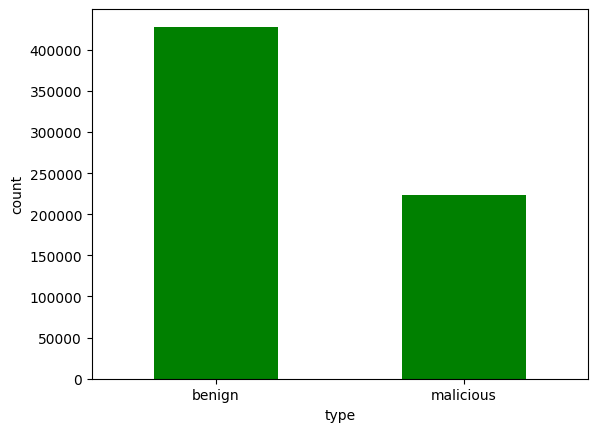

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/dataset.csv',encoding='latin1',on_bad_lines='skip')
df['type'] = df['type'].replace({'defacement': 'malicious', 'phishing': 'malicious', 'malware': 'malicious'})
type_counts=df['type'].value_counts()
type_counts.plot(kind='bar',rot=0,color='green')
plt.xlabel('type')
plt.ylabel('count')
plt.show()

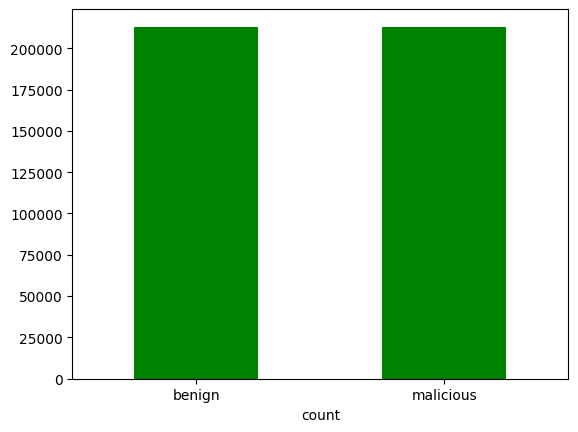

In [ ]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
benign_entries = df[df['type'] == 'benign']
malicious_entries = df[df['type'] == 'malicious']
benign_entries = benign_entries.sample(n=len(malicious_entries), random_state=42)
balanced_df = pd.concat([benign_entries, malicious_entries])
balanced_df = balanced_df.sample(frac=1, random_state=42)
balanced_df.to_csv('balancedData.csv', index=False)
df=pd.read_csv('/content/balancedData.csv')
type_counts=df['type'].value_counts()
type_counts.plot(kind='bar',rot=0,color='green')
plt.xlabel('type')
plt.xlabel('count')
plt.show()

In [ ]:
df['type'] = df['type'].replace({'benign': 0,'malicious':1})
df.to_csv('/content/drive/MyDrive/labelData.csv',index=False)

In [19]:
df=pd.read_csv('/content/drive/MyDrive/labelData.csv')

In [ ]:
df['url']

0                    en.wikipedia.org/wiki/James_Earl_Jones
1                                         rogeranaylor.com/
2                                         consumercares.net
3         http://www.host.hostenx.com/index.php/web-link...
4                        http://211.137.225.61:54118/Mozi.m
                                ...                        
426051             http://digilander.libero.it/riccardog67/
426052                    https://pastebin.com/raw/Earh9hGr
426053      jacksonville.craigslist.org/fuo/2706610364.html
426054    http://torrentdn.com/bbs/s.php?bo_table=torren...
426055                pipl.com/directory/name/Heroux/Heroux
Name: url, Length: 426056, dtype: object

In [ ]:
df['type']

0         0
1         0
2         1
3         1
4         1
         ..
426051    1
426052    1
426053    0
426054    0
426055    0
Name: type, Length: 426056, dtype: int64

### Tokenization

In [20]:
url=list(df['url'])
Type=list(df['type'])

In [21]:
labels=np.array(Type)

In [22]:
def add_spaces_around_punctuation(input_list):
    translation_table = str.maketrans({key: f' {key} ' for key in string.punctuation})
    result_list = [s.translate(translation_table) for s in input_list]
    result_list = [s.split() for s in result_list]

    return result_list

output_list = add_spaces_around_punctuation(url)


output_string = ' '.join([' '.join(words) for words in output_list])


output_string = output_string.replace('[', '').replace(']', '')
#print(output_list)

#print(output_string)


In [ ]:
print(output_list[:40])

[['en', '.', 'wikipedia', '.', 'org', '/', 'wiki', '/', 'James', '_', 'Earl', '_', 'Jones'], ['rogeranaylor', '.', 'com', '/'], ['consumercares', '.', 'net'], ['http', ':', '/', '/', 'www', '.', 'host', '.', 'hostenx', '.', 'com', '/', 'index', '.', 'php', '/', 'web', '-', 'links', '/', '2', '-', 'joomla', '-', 'specific', '-', 'links', '/', '1', '-', 'joomla'], ['http', ':', '/', '/', '211', '.', '137', '.', '225', '.', '61', ':', '54118', '/', 'Mozi', '.', 'm'], ['ahaack', '.', 'net', '/', 'palmpilot', '/', 'palm', '-', 'v', '.', 'html'], ['orindacalifornia', '.', 'com', '/'], ['http', ':', '/', '/', '182', '.', '235', '.', '231', '.', '5', ':', '2093', '/', '.', 'i'], ['mp3lyrics', '.', 'org', '/', 'r', '/', 'ruff', '-', 'ryders', '/', 'dirrty', '/'], ['youtube', '.', 'com', '/', 'watch', '?', 'v', '=', '_', 'baomi0AIyg'], ['http', ':', '/', '/', '192', '.', '236', '.', '155', '.', '130', '/', 'shoppinglistbins', '.', 'sh'], ['hotfile', '.', 'com', '/', 'dl', '/', '14106382', '/', '

In [ ]:
print(output_string[:100])

en . wikipedia . org / wiki / James _ Earl _ Jones rogeranaylor . com / consumercares . net http : /


In [23]:
alist=output_string.split(" ")

In [ ]:
alist[:40]

['en',
 '.',
 'wikipedia',
 '.',
 'org',
 '/',
 'wiki',
 '/',
 'James',
 '_',
 'Earl',
 '_',
 'Jones',
 'rogeranaylor',
 '.',
 'com',
 '/',
 'consumercares',
 '.',
 'net',
 'http',
 ':',
 '/',
 '/',
 'www',
 '.',
 'host',
 '.',
 'hostenx',
 '.',
 'com',
 '/',
 'index',
 '.',
 'php',
 '/',
 'web',
 '-',
 'links',
 '/']

In [24]:
counts = Counter(alist)

In [ ]:
counts

Counter({'en': 21079,
         '.': 989904,
         'wikipedia': 7095,
         'org': 34027,
         '/': 1285328,
         'wiki': 9325,
         'James': 263,
         '_': 170916,
         'Earl': 23,
         'Jones': 59,
         'rogeranaylor': 1,
         'com': 305585,
         'consumercares': 1,
         'net': 26198,
         'http': 148150,
         ':': 191984,
         'www': 113616,
         'host': 218,
         'hostenx': 26,
         'index': 72328,
         'php': 71245,
         'web': 2267,
         '-': 604599,
         'links': 870,
         '2': 8355,
         'joomla': 462,
         'specific': 47,
         '1': 23530,
         '211': 467,
         '137': 319,
         '225': 289,
         '61': 1043,
         '54118': 1,
         'Mozi': 4179,
         'm': 6915,
         'ahaack': 1,
         'palmpilot': 2,
         'palm': 49,
         'v': 5542,
         'html': 80774,
         'orindacalifornia': 1,
         '182': 453,
         '235': 175,
         '2

In [25]:
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

In [ ]:
vocab_to_int

{'/': 1,
 '.': 2,
 '-': 3,
 '=': 4,
 'com': 5,
 '&': 6,
 ':': 7,
 '_': 8,
 'http': 9,
 '%': 10,
 'www': 11,
 '?': 12,
 'html': 13,
 'index': 14,
 'php': 15,
 'id': 16,
 'option': 17,
 'view': 18,
 'org': 19,
 'Itemid': 20,
 'content': 21,
 'net': 22,
 'article': 23,
 '1': 24,
 '+': 25,
 'en': 26,
 'htm': 27,
 'de': 28,
 'component': 29,
 ';': 30,
 'amp': 31,
 'https': 32,
 'co': 33,
 'login': 34,
 'page': 35,
 'uk': 36,
 'catid': 37,
 'tmpl': 38,
 '\\': 39,
 'category': 40,
 'news': 41,
 'wiki': 42,
 'D8': 43,
 'ca': 44,
 'the': 45,
 'us': 46,
 '2': 47,
 'nl': 48,
 'br': 49,
 'in': 50,
 'edu': 51,
 'a': 52,
 '2011': 53,
 'wikipedia': 54,
 'D9': 55,
 'm': 56,
 'it': 57,
 'of': 58,
 'aspx': 59,
 'layout': 60,
 '0': 61,
 '~': 62,
 'wp': 63,
 'au': 64,
 'exe': 65,
 '10': 66,
 'battle': 67,
 'paypal': 68,
 'E3': 69,
 'v': 70,
 'and': 71,
 'print': 72,
 'to': 73,
 '3': 74,
 'ru': 75,
 'default': 76,
 'blog': 77,
 'info': 78,
 'watch': 79,
 'asp': 80,
 "'": 81,
 'cgi': 82,
 's': 83,
 'shop': 

In [26]:
reviews_ints = []
for review in output_list:
    reviews_ints.append([vocab_to_int.get(word, 0) for word in review])

In [ ]:
reviews_ints[:3]

[[54, 2, 19], [113267, 2, 5], [113268, 2, 22]]

In [ ]:
Type[:3]

[0, 0, 1]

In [27]:
lengths = [len(sublist) for sublist in reviews_ints]

max_length = max(lengths)
min_length=min(lengths)
print(max_length)
print(min_length)


326
1


### Padding sequences

In [28]:
def pad_features(reviews_ints, seq_length):


    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]

    return features

In [29]:
seq_length = 326
features = pad_features(reviews_ints, seq_length=seq_length)
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."
print(features[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [ ]:
print(type(features))

<class 'numpy.ndarray'>


In [ ]:
features.shape

(426056, 326)

## Split Data

In [30]:
split_frac = 0.8
split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(remaining_x)*0.1)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

train_x=train_x[:-44]
train_y=train_y[:-44]
val_x=val_x[:-21]
val_y=val_y[:-21]
test_x=test_x[:-91]
test_y=test_y[:-91]


print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(340800, 326) 
Validation set: 	(8500, 326) 
Test set: 		(76600, 326)


## DataLoaders and Batching

In [31]:
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size=100
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [ ]:
Features,Labels=next(iter(train_loader))

In [ ]:
Features.shape

torch.Size([100, 326])

In [ ]:
Labels.shape

torch.Size([100])

In [17]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


## Defining Model

In [5]:
class malicious(nn.Module):
  def __init__(self,vocab_size,output_size,embedding_dim,hidden_dim,n_layers,drop_prob=0.5):
    super(malicious,self).__init__()
    self.output_size=output_size
    self.n_layers=n_layers
    self.hidden_dim=hidden_dim
    self.embedding=nn.Embedding(vocab_size,embedding_dim)
    self.lstm=nn.LSTM(embedding_dim,hidden_dim,n_layers,dropout=drop_prob,batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.fc=nn.Linear(hidden_dim,output_size)

  def forward(self,x,hidden):
    batch_size=x.size(0)
    x=x.long()
    embeds=self.embedding(x)
    lstm_out,hidden=self.lstm(embeds,hidden)
    lstm_out=lstm_out[:, -1, :] # getting the last time step output
    output=self.dropout(lstm_out)
    output=F.sigmoid(self.fc(output))
    return output,hidden

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
    else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

    return hidden

## Defining Hyperparameters

In [8]:
vocab_size=len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size=1
embedding_dim=400
hidden_dim=256
n_layers=2

model=malicious(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(model)

malicious(
  (embedding): Embedding(415296, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


## Training

In [9]:
criterion=nn.BCELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [ ]:
epochs=5
counter=0
print_every=100
clip=5
if(train_on_gpu):
    model.cuda()
model.train()
for e in range(epochs):
  h=model.init_hidden(batch_size)
  for Features,Labels in train_loader:
    counter+=1
    if(train_on_gpu):
      Features,Labels=Features.cuda(),Labels.cuda()
    h=tuple([each.data for each in h])
    model.zero_grad()
    output,h=model(Features,h)
    loss=criterion(output.squeeze(),Labels.float())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(),clip) # prevent the exploding gradient problem
    optimizer.step()

    if(counter % print_every==0):
      with torch.no_grad():
        val_h = model.init_hidden(batch_size)
        val_losses = []
        num_correct = 0
        model.eval()
        for Features,Labels in valid_loader:
          val_h = tuple([each.data for each in val_h])
          if(train_on_gpu):
            Features,Labels=Features.cuda(),Labels.cuda()
          output, val_h = model(Features,val_h)
          val_loss = criterion(output.squeeze(), Labels.float())
          val_losses.append(val_loss.item())
          pred = torch.round(output.squeeze())
          correct_tensor = pred.eq(Labels.float().view_as(pred))
          correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
          num_correct += np.sum(correct)
          accuracy = num_correct/len(valid_loader.dataset)
        model.train()
        checkpoint = {'vocab_size': vocab_size,
              'output_size': model.output_size,
              'embedding_dim': embedding_dim,
              'hidden_dim':model.hidden_dim,
              'n_layers':model.n_layers,
              'batch_size':batch_size,
              'state_dict': model.state_dict()}
        torch.save(checkpoint, '/content/drive/MyDrive/checkpoint.pth')
        print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)),
              "Validation accuracy: {:.3f}".format(accuracy))
    print("Epoch: {}/{}...".format(e+1, epochs),"Step: {}...".format(counter))


Streaming output truncated to the last 5000 lines.
Epoch: 4/5... Step: 12091...
Epoch: 4/5... Step: 12092...
Epoch: 4/5... Step: 12093...
Epoch: 4/5... Step: 12094...
Epoch: 4/5... Step: 12095...
Epoch: 4/5... Step: 12096...
Epoch: 4/5... Step: 12097...
Epoch: 4/5... Step: 12098...
Epoch: 4/5... Step: 12099...
Epoch: 4/5... Step: 12100... Loss: 0.000436... Val Loss: 0.076226 Validation accuracy: 0.981
Epoch: 4/5... Step: 12100...
Epoch: 4/5... Step: 12101...
Epoch: 4/5... Step: 12102...
Epoch: 4/5... Step: 12103...
Epoch: 4/5... Step: 12104...
Epoch: 4/5... Step: 12105...
Epoch: 4/5... Step: 12106...
Epoch: 4/5... Step: 12107...
Epoch: 4/5... Step: 12108...
Epoch: 4/5... Step: 12109...
Epoch: 4/5... Step: 12110...
Epoch: 4/5... Step: 12111...
Epoch: 4/5... Step: 12112...
Epoch: 4/5... Step: 12113...
Epoch: 4/5... Step: 12114...
Epoch: 4/5... Step: 12115...
Epoch: 4/5... Step: 12116...
Epoch: 4/5... Step: 12117...
Epoch: 4/5... Step: 12118...
Epoch: 4/5... Step: 12119...
Epoch: 4/5... S

## Checkpoint

In [ ]:
checkpoint = {'vocab_size': vocab_size,
              'output_size': model.output_size,
              'embedding_dim': embedding_dim,
              'hidden_dim':model.hidden_dim,
              'n_layers':model.n_layers,
              'batch_size':batch_size,
              'vocab_to_int':vocab_to_int,
              'state_dict': model.state_dict()}

In [ ]:
torch.save(checkpoint, '/content/drive/MyDrive/checkpoint.pth')

In [34]:
checkpoint = torch.load('/content/drive/MyDrive/checkpoint.pth')

In [13]:
vocab_size=checkpoint['vocab_size']
vocab_to_int=checkpoint['vocab_to_int']
batch_size=checkpoint['batch_size']

In [35]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [36]:
model.state_dict()

OrderedDict([('embedding.weight',
              tensor([[-0.1730,  0.3771,  0.8443,  ..., -1.1336, -1.1474,  1.5201],
                      [-0.1076, -0.5881, -1.0230,  ..., -0.7631,  0.0823, -0.5959],
                      [-0.7707, -1.2777,  0.6377,  ...,  1.1207,  0.1828,  1.0597],
                      ...,
                      [-0.4303, -0.8565,  1.5830,  ..., -0.4029, -0.8758,  0.7701],
                      [-0.4772, -0.6745, -0.0335,  ...,  1.2712,  1.1152,  0.2482],
                      [-0.5639, -0.5391,  0.2881,  ..., -0.9421, -1.8101, -0.1846]],
                     device='cuda:0')),
             ('lstm.weight_ih_l0',
              tensor([[-0.0044, -0.1230, -0.0274,  ..., -0.1166, -0.2248, -0.1058],
                      [ 0.2196, -0.0489,  0.1009,  ..., -0.1947, -0.1046, -0.3388],
                      [ 0.1667,  0.0143, -0.1228,  ...,  0.1257,  0.1989, -0.1003],
                      ...,
                      [-0.0272, -0.1672,  0.0829,  ...,  0.2992, -0.0020,  0.128

## Testing

In [37]:
with torch.no_grad():
  model.cuda()
  test_losses = []
  num_correct = 0
  h = model.init_hidden(batch_size)
  model.eval()
  for Features, Labels in test_loader:
      h = tuple([each.data for each in h])
      if(train_on_gpu):
          Features, Labels = Features.cuda(), Labels.cuda()
      output,h = model(Features,h)
      test_loss = criterion(output.squeeze(), Labels.float())
      test_losses.append(test_loss.item())
      pred = torch.round(output.squeeze())
      correct_tensor = pred.eq(Labels.float().view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      num_correct += np.sum(correct)

  print("Test loss: {:.3f}".format(np.mean(test_losses)))

  test_acc = num_correct/len(test_loader.dataset)
  print("Test accuracy: {:.3f}".format(test_acc))
  feature_tensor = torch.from_numpy(features)

Test loss: 0.096
Test accuracy: 0.980


## Inference


In [33]:
def add_spaces_around_punctuation(input_list):
    translation_table = str.maketrans({key: f' {key} ' for key in string.punctuation})
    result_list = [s.translate(translation_table) for s in input_list]
    result_list = [s.split() for s in result_list]

    return result_list

def pad_features(reviews_ints, seq_length):
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    return features

def predict(feature_tensor):
  with torch.no_grad():
    h = model.init_hidden(feature_tensor.size(0))
    model.eval()
    h = tuple([each.data for each in h])
    if(train_on_gpu):
      feature_tensor= feature_tensor.cuda()
    output,h = model(feature_tensor,h)
    pred = torch.round(output.squeeze())
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    if(pred.item()==0):
      print("Not Malicious")
    else:
      print("Malicious")

url=[input("Enter Url: ")]
output_list = add_spaces_around_punctuation(url)

reviews_ints = []
for review in output_list:
    reviews_ints.append([vocab_to_int.get(word, 0) for word in review])

seq_length = 326
features = pad_features(reviews_ints, seq_length=seq_length)
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."
feature_tensor=torch.from_numpy(features)
predict(feature_tensor)

Enter Url: facebook.com
Prediction value, pre-rounding: 0.477442
Not Malicious
